In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from torch.utils.data import DataLoader
from torch_geometric.nn import LightGCN
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from utils import *
pd.set_option('display.max_colwidth', None)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
columns_name=['user_id','item_id','rating','timestamp']
df = pd.read_csv("../data/ml-100k/u.data",sep="\t",names=columns_name)
# remove low rating
df = df[df['rating']>=3]

In [4]:
# train test split
train_df, test_df = train_test_split(df, test_size=0.3, random_state=16)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=16)
# train_df = pd.DataFrame(train, columns=df.columns)
# val_df = pd.DataFrame(val, columns=df.columns)
# test_df = pd.DataFrame(test, columns=df.columns)

In [5]:
print("Train Size  : ", len(train_df))
print("Val Size : ", len (val_df))
print("Test Size : ", len (test_df))

Train Size  :  57764
Test Size :  12378
Test Size :  12378


In [7]:
# relabeling nodes
# le_user = pp.LabelEncoder()
# le_item = pp.LabelEncoder()
# train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
# train_df['item_id_idx'] = le_item.fit_transform(train_df['item_id'].values)

In [8]:
# remove user item in test but not in train
# train_user_ids = train_df['user_id'].unique()
# train_item_ids = train_df['item_id'].unique()
# test_df = test_df[
#   (test_df['user_id'].isin(train_user_ids)) & \
#   (test_df['item_id'].isin(train_item_ids))
# ]
# test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
# test_df['item_id_idx'] = le_item.transform(test_df['item_id'].values)

In [148]:
# n_users = train_df['user_id_idx'].nunique()
# n_items = train_df['item_id_idx'].nunique()
# print("Number of Unique Users : ", n_users)
# print("Number of unique Items : ", n_items)
# print('Size of test set before/ after(remove user/item not in train set):', len(test), len(test_df))

In [ ]:
# test_x = torch.Tensor(np.eye(5))
# test_edge_index = torch.LongTensor(np.array([
#   [0, 0, 1, 1, 2, 3, 3, 4],
#   [2, 3, 3, 4, 0, 0, 1, 1]
# ]))

# sample = train_df.head(50)
# le_user = pp.LabelEncoder()
# le_item = pp.LabelEncoder()
# sample['user_id_idx'] = le_user.fit_transform(sample['user_id'].values)
# sample['item_id_idx'] = le_item.fit_transform(sample['item_id'].values)
# sample
# sampleU = sample['user_id_idx'].unique()
# sampleI = sample['item_id_idx'].unique()
# test_df = test_df[(test_df['user_id_idx'].isin(sampleU) & test_df['item_id_idx'].isin(sampleI))]  #66*6
# sampleU
# test_df['item_id_idx'].unique()

In [140]:
# tt = df_to_graph(train_df, n_users)
# tt.shape
# users, pos_items, neg_items, usr_pos_label, usr_neg_label = \
#     pos_neg_edge_index(sample, 47, 48)
# users, pos_items, neg_items, usr_pos_label, usr_neg_label = \
#     pos_neg_edge_index(train_df, n_users, n_items)
# usr_pos_label -- 2 * 66016; usr_neg_label -- 2 * 66016
# assert len(usr_pos_label[0]) == len(train_df)

In [141]:
# latent_dim = 64
# n_layers = 3
# EPOCHS = 50
# BATCH_SIZE = 1024
# # DECAY = 0.0001
# LR = 0.005
# K = 20

In [6]:
n_users, n_items, train_df, val_df, test_df = prepare_val_test(train_df, val_df, test_df)

/Users/yingkang/4thBrain/GNN-eCommerce/notebooks/utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['user_id_idx'] = le_user.transform(val_df['user_id'].values)
/Users/yingkang/4thBrain/GNN-eCommerce/notebooks/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['item_id_idx'] = le_item.transform(val_df['item_id'].values)
/Users/yingkang/4thBrain/GNN-eCommerce/notebooks/utils.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [7]:
print("Train Size  : ", len(train_df))
print("Val Size : ", len (val_df))
print("Test Size : ", len (test_df))
print("Users : ", n_users)
print("Items : ", n_items)

Train Size  :  57764
Val Size :  12358
Test Size :  12349
Users :  943
Items :  1530


In [8]:
latent_dim = 64
n_layers = 3
LR = 0.005

model = LightGCN(num_nodes=n_users+n_items, embedding_dim=latent_dim, num_layers=n_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(model.parameters())])

Size of Learnable Embedding :  [torch.Size([2473, 64])]


In [9]:
def train_and_evl(model, train_df, n_users, n_items, optimizer, val_df, EPOCHS = 50, BATCH_SIZE = 1024, K = 20, DECAY = 0.0001):
    edge_index = df_to_graph(train_df, n_users).to(device)

    bpr_loss_epoch_list = []
    reg_loss_epoch_list = []
    final_loss_epoch_list = []
    recall_epoch_list = []
    precision_epoch_list = []

    idx = list(range(len(train_df)))
    random.shuffle(idx)
    loader = DataLoader(idx, batch_size=BATCH_SIZE, shuffle=True)

    print('bpr_loss \t reg_loss \t final_loss \t precision \t recall')
    for epoch in tqdm(range(EPOCHS)):
        # bpr_loss_batch_list = []
        # reg_loss_batch_list = []
        # final_loss_batch_list = []
        #
        # users, pos_items, neg_items= pos_neg_edge_index(train_df, n_users, n_items)
        # model.train()
        # for batch in loader:
        #     optimizer.zero_grad()
        #
        #     batch_usr = users[batch]
        #     batch_pos_items = pos_items[batch]
        #     batch_neg_items = neg_items[batch]
        #
        #     batch_pos_neg_labels = batch_pos_neg_edges(batch_usr, batch_pos_items, batch_neg_items).to(device)
        #     out = model(edge_index, batch_pos_neg_labels)
        #     size = len(batch)
        #
        #     bpr_loss = model.recommendation_loss(out[:size], out[size:], 0) * size
        #     reg_loss = regularization_loss(model.embedding.weight, size, batch_usr, batch_pos_items, batch_neg_items)
        #     loss = bpr_loss + reg_loss
        #
        #     # print("bpr loss: ", loss, "reg loss: ", reg_loss)
        #     loss.backward()
        #     optimizer.step()
        #
        #     bpr_loss_batch_list.append(bpr_loss.item())
        #     reg_loss_batch_list.append(reg_loss.item())
        #     final_loss_batch_list.append(loss.item())
        # bpr_loss = round(np.mean(bpr_loss_batch_list), 4)
        # reg_loss = round(np.mean(reg_loss_batch_list), 4)
        # final_loss = round(np.mean(final_loss_batch_list), 4)

        bpr_loss, reg_loss, final_loss = train_loop(model, train_df, n_users, n_items, edge_index, optimizer, loader)

        # model.eval()
        # with torch.no_grad():
        #     embeds = model.get_embedding(edge_index)
        #     final_usr_embed, final_item_embed = torch.split(embeds, (n_users, n_items))
        #     matrix = interact_matrix(train_df, n_users, n_items).to(device)
        #     test_topK_recall, test_topK_precision = get_metrics(final_usr_embed, final_item_embed, matrix, val_df, K)
        # precision = round(test_topK_precision, 4)
        # recall = round(test_topK_recall, 4)

        precision, recall = evaluation(model, train_df, n_users, n_items, edge_index, val_df, K)

        print(bpr_loss, reg_loss, final_loss, precision, recall)
        bpr_loss_epoch_list.append(bpr_loss)
        reg_loss_epoch_list.append(reg_loss)
        final_loss_epoch_list.append(final_loss)
        recall_epoch_list.append(recall)
        precision_epoch_list.append(precision)

    return (
        bpr_loss_epoch_list,
        reg_loss_epoch_list,
        final_loss_epoch_list,
        recall_epoch_list,
        precision_epoch_list)

In [10]:
bpr_loss, reg_loss, final_loss, recall, precision = train_and_evl(model, train_df, n_users, n_items, optimizer, val_df)

bpr_loss 	 reg_loss 	 final_loss 	 precision 	 recall


  0%|          | 0/50 [00:00<?, ?it/s]

0.5137 0.0002 0.5139 0.0907 0.1689
0.3651 0.0004 0.3655 0.0966 0.1797
0.3492 0.0004 0.3497 0.1056 0.2111
0.3301 0.0005 0.3306 0.118 0.2419
0.3099 0.0006 0.3105 0.1197 0.2433
0.2976 0.0007 0.2983 0.1197 0.2417
0.2857 0.0008 0.2865 0.1222 0.2445
0.2747 0.0009 0.2756 0.1293 0.2545
0.2596 0.001 0.2606 0.1327 0.2602
0.2476 0.0012 0.2487 0.1351 0.2658
0.2457 0.0013 0.247 0.1351 0.267
0.2438 0.0013 0.2452 0.1391 0.2753
0.2398 0.0014 0.2413 0.1409 0.2821
0.2354 0.0015 0.2369 0.1406 0.2822
0.2277 0.0016 0.2293 0.143 0.2874
0.2249 0.0017 0.2266 0.1446 0.2903
0.2184 0.0018 0.2201 0.1452 0.2911
0.2163 0.0019 0.2182 0.1458 0.2933
0.2107 0.002 0.2127 0.1476 0.2961
0.2064 0.0021 0.2084 0.1497 0.2966
0.2065 0.0022 0.2086 0.1503 0.2967
0.2031 0.0023 0.2053 0.1511 0.2987
0.2022 0.0023 0.2045 0.1508 0.298
0.1958 0.0024 0.1982 0.1503 0.2955
0.1903 0.0025 0.1928 0.1503 0.2928
0.1887 0.0026 0.1913 0.1518 0.299
0.1879 0.0027 0.1907 0.1508 0.2956
0.1827 0.0028 0.1855 0.1517 0.2965
0.1833 0.0029 0.1863 0.151 0

In [11]:
epoch_list = [(i+1) for i in range(50)]

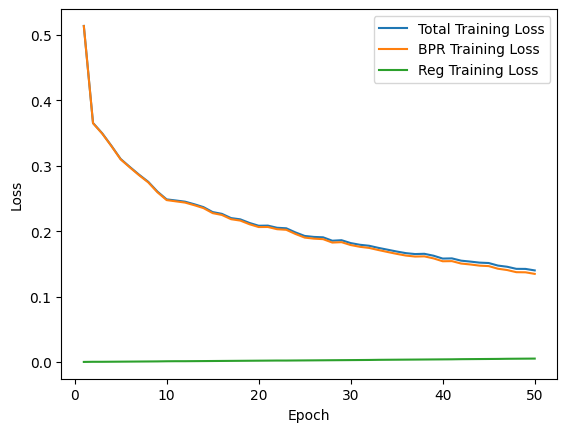

In [12]:
plt.plot(epoch_list, final_loss, label='Total Training Loss')
plt.plot(epoch_list, bpr_loss, label='BPR Training Loss')
plt.plot(epoch_list, reg_loss, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

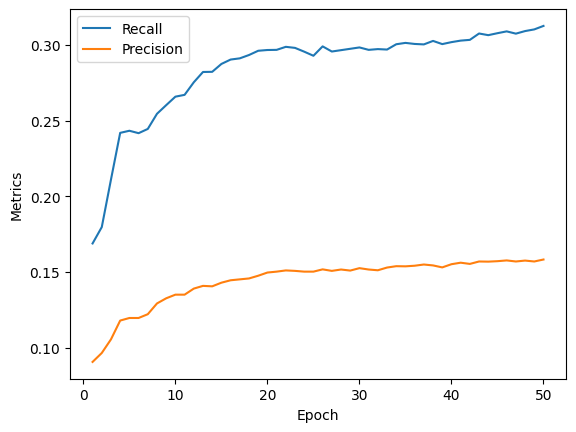

In [13]:
plt.plot(epoch_list, recall, label='Recall')
plt.plot(epoch_list, precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

In [14]:
max(precision), max(recall)

(0.1583, 0.3125)

In [15]:
edge_index = df_to_graph(train_df, n_users).to(device)

In [16]:
evaluation(model, train_df, n_users, n_items, edge_index, test_df, K=20)

(0.1559, 0.3144)

In [17]:
# bpr_loss, reg_loss, final_loss, recall, precision = train_and_evl(model, optimizer, train_df, val_df)

  0%|          | 0/50 [00:00<?, ?it/s]

0.4899 0.0002 0.4901 0.131 0.1802
0.3513 0.0004 0.3517 0.1388 0.195
0.3335 0.0005 0.3339 0.1592 0.2431
0.3107 0.0005 0.3113 0.1698 0.2608
0.2934 0.0007 0.294 0.1747 0.2613
0.2824 0.0008 0.2832 0.1802 0.2664
0.2688 0.0009 0.2697 0.1874 0.2755
0.2534 0.001 0.2545 0.1959 0.2891
0.2417 0.0012 0.2429 0.1958 0.2917
0.2359 0.0013 0.2372 0.1981 0.2942
0.2307 0.0014 0.2321 0.2004 0.2989
0.2278 0.0014 0.2293 0.2018 0.303
0.2229 0.0015 0.2244 0.2046 0.3079
0.2219 0.0016 0.2235 0.2075 0.3121
0.2152 0.0017 0.2169 0.2093 0.3127
0.2114 0.0018 0.2132 0.21 0.3132
0.2051 0.0019 0.207 0.2131 0.3184
0.2047 0.002 0.2067 0.2145 0.3193
0.1982 0.0021 0.2003 0.2163 0.3201
0.1923 0.0022 0.1945 0.2171 0.3175
0.1911 0.0023 0.1934 0.217 0.3209
0.189 0.0024 0.1914 0.2184 0.322
0.1857 0.0025 0.1882 0.219 0.3239
0.1841 0.0026 0.1867 0.2193 0.3228
0.1783 0.0027 0.181 0.2214 0.3264
0.1777 0.0028 0.1805 0.2206 0.3251
0.1774 0.0029 0.1803 0.2237 0.3286
0.174 0.003 0.177 0.224 0.329
0.1727 0.0031 0.1758 0.2238 0.3295
0.17

In [319]:
# test_x = torch.Tensor(np.eye(5))
# test_edge_index = torch.LongTensor(np.array([
#   [0, 0, 1, 2, 3, 3],
#   [2, 3, 4, 0, 0, 1]
# ]))
#
# pos_label = torch.LongTensor(np.array([
#   [0, 0, 1],
#   [2, 3, 4]
# ]))
# neg_label = torch.LongTensor(np.array([
#   [0, 0, 1],
#   [4, 5, 2]
# ]))
# total_label = torch.cat([pos_label, neg_label], dim=1)

In [392]:
# recommendation_loss_list = []
# model.train()
# edge_index = df_to_graph(sample, 47)
# for batch in loader:
#     optimizer.zero_grad()
#
#     pos_train_edge_label = usr_pos_label[:,batch]
#     neg_train_edge_label = usr_neg_label[:,batch]
#     # print(pos_train_edge_label)
#     # print(neg_train_edge_label)
#     total_label = torch.cat([pos_train_edge_label, neg_train_edge_label], dim=1)
#
#     out = model(edge_index, total_label)
#     # print(out)
#     size = len(pos_train_edge_label[0])
#     loss = model.recommendation_loss(out[:size], out[size:])
#     # print(loss)
#     recommendation_loss_list.append(loss.item())
#
# model.eval()
# with torch.no_grad():
#     embeds = model.get_embedding(edge_index)
#     final_usr_embed, final_item_embed = torch.split(embeds, (47, 48))
#     # print(final_usr_embed.shape)
#     test_topK_recall, test_topK_precision = get_metrics(final_usr_embed, final_item_embed, 47, 48, sample, test_df, 2)
#
# print(recommendation_loss_list)
# print(test_topK_recall)
# print(test_topK_precision)

[0.12924085557460785, 0.1303127408027649]
0.019230769230769232
0.019230769230769232


In [381]:
# def get_metrics_1(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
#   # compute the score of all user-item pairs
#   relevance_score = user_Embed_wts @ item_Embed_wts.t()
#
#   # create dense tensor of all user-item interactions
#   i = torch.stack((
#     torch.LongTensor(train_data['user_id_idx'].values),
#     torch.LongTensor(train_data['item_id_idx'].values)
#   ))
#   v = torch.ones((len(train_data)), dtype=torch.float64)
#   interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items)).to_dense().to(device)
#
#   # mask out training user-item interactions from metric computation
#   relevance_score = torch.mul(relevance_score, (1 - interactions_t))
#
#   # compute top scoring items for each user
#   topk_relevance_indices = torch.topk(relevance_score, K).indices
#   topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy())
#   topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df.values.tolist()
#   topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
#   topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]
#
#   # measure overlap between recommended (top-K) and held-out user-item interactions
#   test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
#   metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
#   # print(metrics_df)
#   metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)] #TP
#
#   metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1)
#   metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)
#
#   return metrics_df['recall'].mean(), metrics_df['precision'].mean()

In [ ]:
# test_topK_recall, test_topK_precision = get_metrics_1(final_usr_embed, final_item_embed, 47, 48, sample, test_df, 2)
# print("recall@K: ", test_topK_recall, " precision@K: ", test_topK_precision)

In [ ]:
# from torch_geometric.transforms import RandomLinkSplit
#
# transform = RandomLinkSplit(is_undirected=False, split_labels=True, add_negative_train_samples=True, num_val=0, num_test=2)
# train_data, val_data, test_data = transform(data)

In [ ]:
# print(train_data.pos_edge_label_index)
# print(val_data.pos_edge_label_index)
# print(test_data.pos_edge_label_index)